# Validation of the correlation functions

Here we test the implementation of the correlation functions by computing the product $B.x$ where $x$ is an impulse; i.e. is equal to 1 at the center of the domain and 0 elsewhere.

The result plotted a a function of distance to the center return the covariance function.

- For **Covariance type = String "full-Matrix"** the covariance Matrix is directly computed from the implemented correlation functions as a function of the distance between the nodes, so differences with the anlytical solutions should be of order $\epsilon$

-  For **Covariance type = String "diffusion operator"** the covariance matrix is approximated by iteratively solving a diffusion type equation, and thus differences are expected to be larger, especially close to the boundaries. 

In [1]:
import scipy
import numpy as np
import xugrid as xu
import xarray as xr
import os
import sys
import meshio
import matplotlib.pyplot as plt
from numba_celltree.celltree import(cast_vertices, cast_faces)

### https://gricad-gitlab.univ-grenoble-alpes.fr/gilletcf/elmerugrid
sys.path.insert(0, os.path.abspath('../../elmerugrid'))

from ElmerUgrid import ugrid
from ElmerUgrid.fem import TriIntegrate
from ElmerUgrid.Interpolation import *

## Analytical correlation functions

In [2]:
def matern(l, r, nu):
    """Computes Matérn correlation function for given distances and parameters
    Parameters:
    -----------
    l : array
        Distances between locations.
    r : float
        Range parameter. Must be greater than 0.
    nu : float
        Smoothness parameter. Must be greater than 0.
    Returns:
    --------
    Array giving Matern correlation for given distances.
    """
    assert r > 0
    assert nu > 0
    eps=np.finfo(np.float32).eps
    d=np.where( l == 0.0,eps,l)
    a = (2**(nu - 1) * scipy.special.gamma(nu))**(-1)
    b = (d / r)**nu * scipy.special.kv(nu, d / r)
    return a * b

def gaussian(l, r):
    """Computes gaussian correlation function for given distances and range
    Parameters:
    -----------
    l : array
        Distances between locations.
    r : float
        Range parameter. Must be greater than 0.
    Returns:
    --------
    Array giving Matern correlation for given distances.
    """
    assert r > 0
    eps=np.finfo(np.float32).eps
    d=np.where( l == 0.0,eps,l)
    out=np.exp(-d**2/(2*r**2))
    return out

## Load mesh

In [3]:
mesh_name="square"
elmer_grid=xu.Ugrid2d.FromElmer(mesh_name)
#elmer_grid.plot()

## Prepare interpolation weights to interpolate nodal results
## on a cross-section
area= xu.UgridDataArray(
       xr.DataArray(
         data=elmer_grid.area,
         name="area",
         dims=[elmer_grid.face_dimension],
         attrs=dict(mesh=elmer_grid.name,location="face")),
      elmer_grid)

line = area.ugrid.sel(y=0.0)
axis_name=area.grid.name+"_s"
## Baricentric interpolation at the given points
points=np.vstack((line.mesh2d_x.values,line.mesh2d_y.values)).T
LineWeights,out = barycentric_interpolator(points, elmer_grid)


## Compute analytical correlation on the mesh

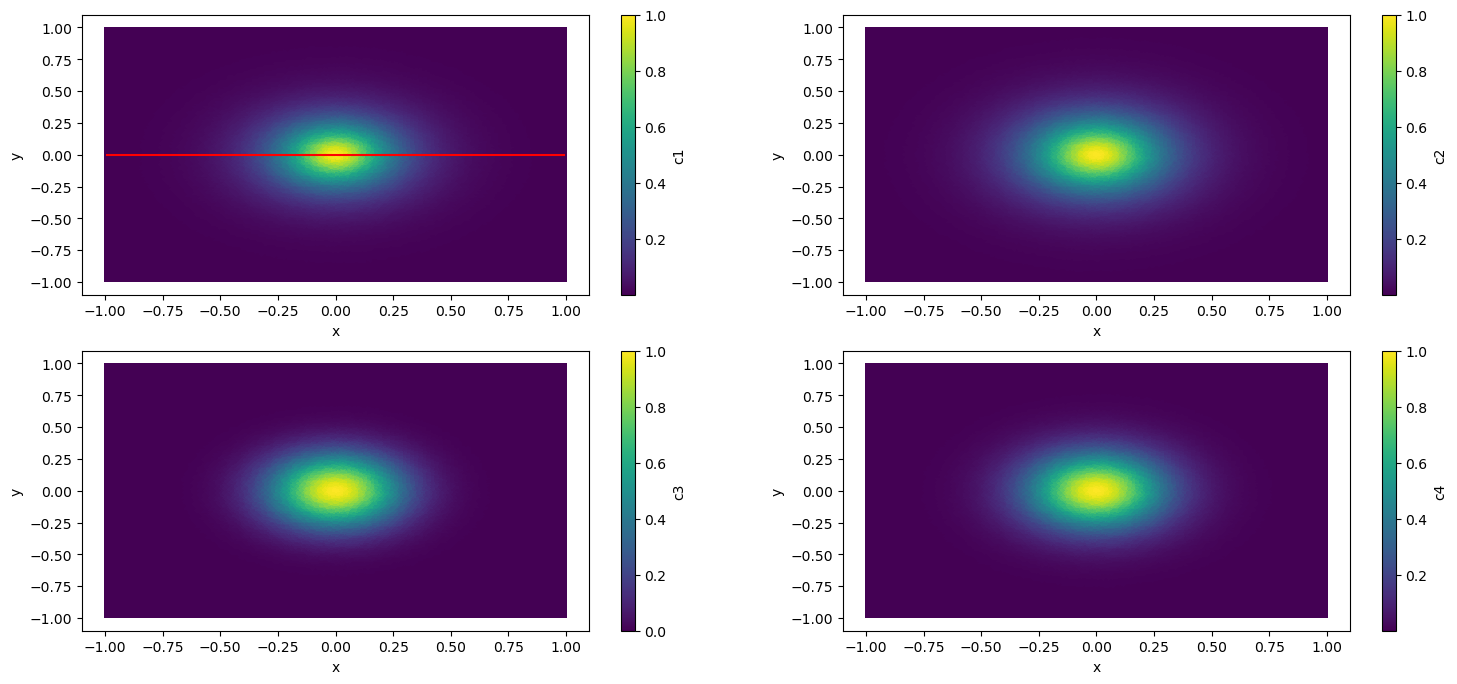

Text(0.5, 0, 'covariance')

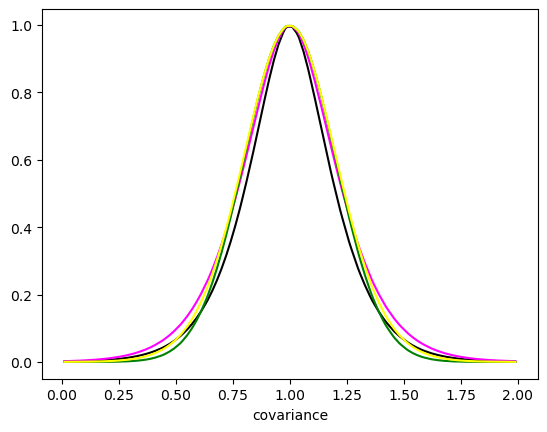

In [4]:
d=np.sqrt((elmer_grid.node_coordinates[:,0]-0.0)**2+(elmer_grid.node_coordinates[:,1]-0.0)**2)

## The different test cases:
nu=2
range=0.1
c1=matern(d,range,nu)

c1_da = xu.UgridDataArray(
       xr.DataArray(
         data=c1,
         name="c1",
         dims=[elmer_grid.node_dimension],
         attrs=dict(mesh=elmer_grid.name,location="node")),
      elmer_grid)

p=2
nu=p+0.5
range=0.1
c2=matern(d,range,nu)
c2_da = xu.UgridDataArray(
       xr.DataArray(
         data=c2,
         name="c2",
         dims=[elmer_grid.node_dimension],
         attrs=dict(mesh=elmer_grid.name,location="node")),
      elmer_grid)

range=0.2
c3=gaussian(d,range)
c3_da = xu.UgridDataArray(
       xr.DataArray(
         data=c3,
         name="c3",
         dims=[elmer_grid.node_dimension],
         attrs=dict(mesh=elmer_grid.name,location="node")),
      elmer_grid)

nu=10
range=0.2
rangem=range/np.sqrt(2*(nu+1)-4)
c4=matern(d,rangem,nu)
c4_da = xu.UgridDataArray(
       xr.DataArray(
         data=c4,
         name="c4",
         dims=[elmer_grid.node_dimension],
         attrs=dict(mesh=elmer_grid.name,location="node")),
      elmer_grid)


c1_line=LineWeights*c1_da
c2_line=LineWeights*c2_da
c3_line=LineWeights*c3_da
c4_line=LineWeights*c4_da


fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(ncols=2,nrows=2,figsize=(18, 8))
c1_da.ugrid.plot(ax=ax1)
c2_da.ugrid.plot(ax=ax2)
c3_da.ugrid.plot(ax=ax3)
c4_da.ugrid.plot(ax=ax4)
ax1.plot(points[:,0],points[:,1],color="red")
plt.show()

plt.plot()
plt.plot(line[axis_name].values,c1_line,'k') 
plt.plot(line[axis_name].values,c2_line,color="magenta") 
plt.plot(line[axis_name].values,c3_line,color="green") 
plt.plot(line[axis_name].values,c4_line,color="yellow") 
plt.xlabel("distance")
plt.xlabel("covariance")




# Compare to results from Case_1

This set-up test the different implementations of the Matern correlation functions

In [5]:
result=meshio.read(os.path.join(mesh_name,"Case_1_t0001.vtu"))

# full-matrix maternp (compare to c2)
res1=result.point_data['corrmp'][:,0]
# full-matrix maternI (compare to c1)
res2=result.point_data['corrmi'][:,0]
# diffusion operator (compare to c1)
res3=result.point_data['corrdo'][:,0]

res_da1 = xu.UgridDataArray(
       xr.DataArray(
         data=res1,
         name="cor",
         dims=[elmer_grid.node_dimension],
         attrs=dict(mesh=elmer_grid.name,location="node")),
      elmer_grid)
res_line1 = LineWeights*res_da1.values

res_da2 = xu.UgridDataArray(
       xr.DataArray(
         data=res2,
         name="cor",
         dims=[elmer_grid.node_dimension],
         attrs=dict(mesh=elmer_grid.name,location="node")),
      elmer_grid)
res_line2 = LineWeights*res_da2.values

res_da3 = xu.UgridDataArray(
       xr.DataArray(
         data=res3,
         name="cor",
         dims=[elmer_grid.node_dimension],
         attrs=dict(mesh=elmer_grid.name,location="node")),
      elmer_grid)
res_line3 = LineWeights*res_da3.values



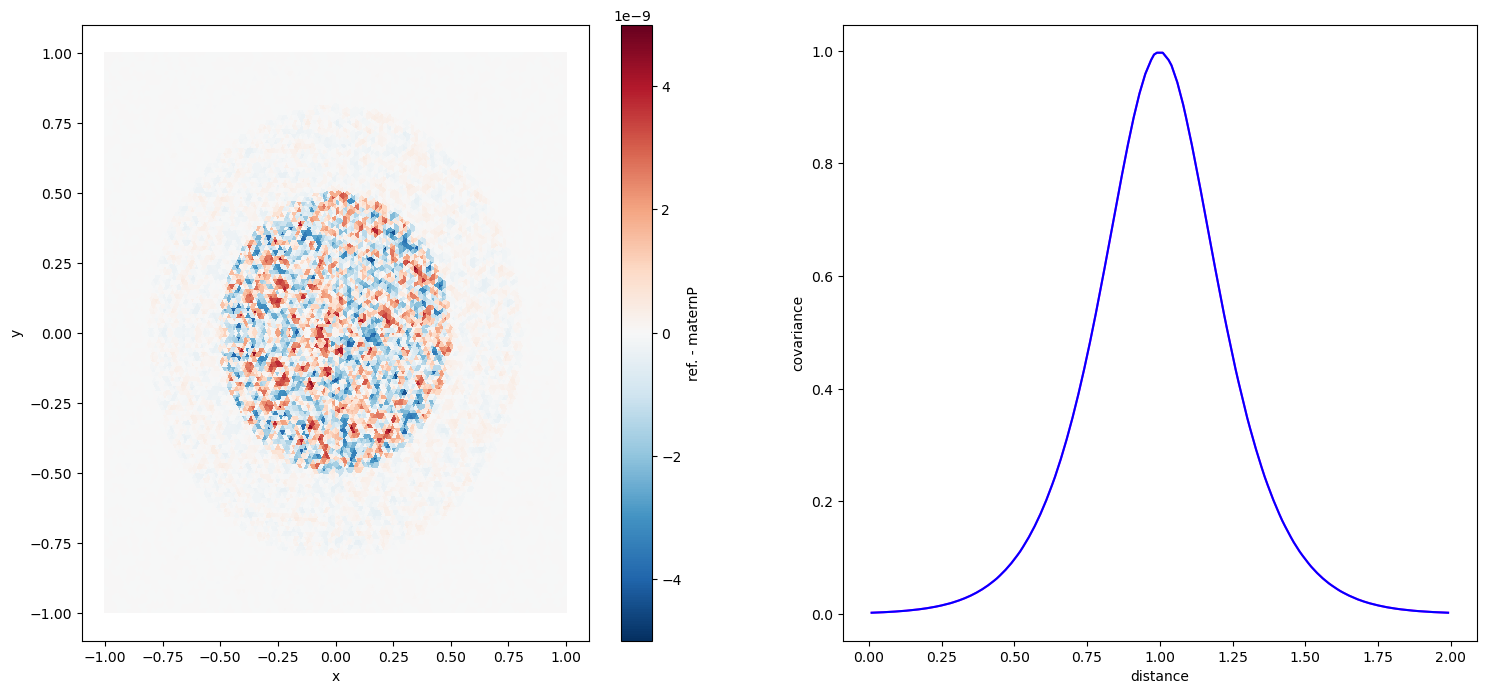

In [6]:
diff1=c2_da-res_da1
# Plot unstructured grid and cross section
fig1, (ax0, ax1) = plt.subplots(ncols=2,figsize=(18, 8))
diff1.ugrid.plot(ax=ax0,cbar_kwargs={'label': "ref. - maternP"})


ax1.plot(line[axis_name].values,c2_line,'magenta') 
ax1.plot(line[axis_name].values,res_line1,color="blue") 
plt.xlabel("distance")
plt.ylabel("covariance")
plt.show()


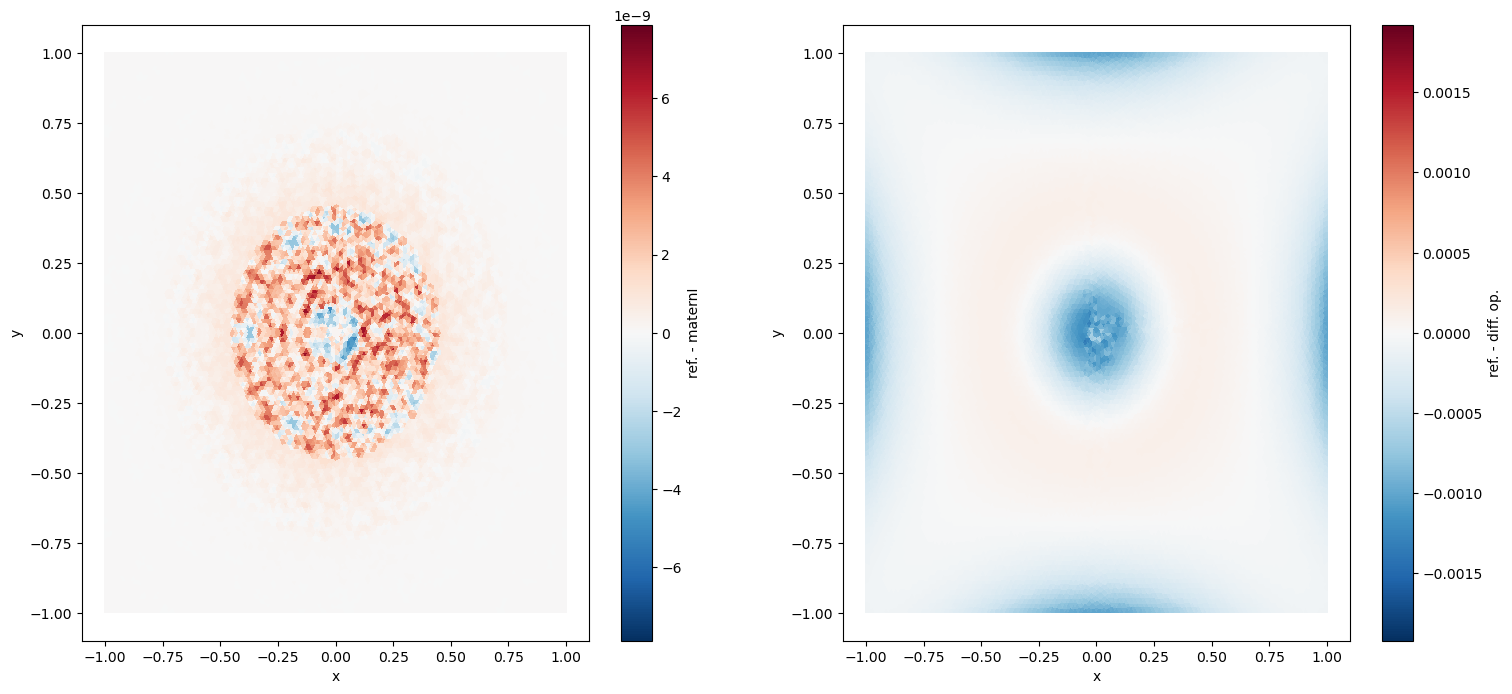

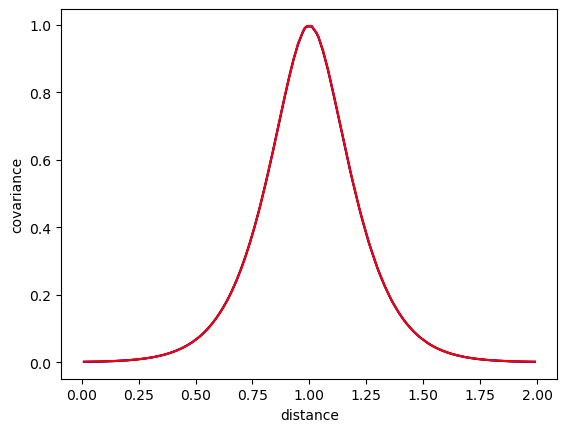

In [7]:
diff2=c1_da-res_da2
diff3=c1_da-res_da3

# Plot unstructured grid and cross section
fig1, (ax0, ax1) = plt.subplots(ncols=2,figsize=(18, 8))
diff2.ugrid.plot(ax=ax0,cbar_kwargs={'label': "ref. - maternI"})
diff3.ugrid.plot(ax=ax1,cbar_kwargs={'label': "ref. - diff. op."})

plt.show()

fig=plt.plot()
plt.plot(line[axis_name].values,c1_line,'k') 
plt.plot(line[axis_name].values,res_line2,color="blue") 
plt.plot(line[axis_name].values,res_line3,color="red")
plt.xlabel("distance")
plt.ylabel("covariance")
plt.show()
#

# Compare to results from Case_2

The Matern function with $\nu \to \infty$ whith a range given by $r=l/\sqrt{2(\nu+1)-4}$ should converge to the gaussian correlation $c(d)=e^{-d^2/(2l^2)}$

This set-up test the gaussian function implementation and compare the Matern implementation with $\nu=10$ for the "full-matrix" and "diffusion operator" methods


In [8]:
result2=meshio.read(os.path.join(mesh_name,"Case_2_t0001.vtu"))

# full-matrix gaussian (compare to c3)
res4=result2.point_data['corrgaussian'][:,0]
# full-matrix maternI (compare to c4)
res5=result2.point_data['corrmi'][:,0]
# diffusion operator (compare to c4)
res6=result2.point_data['corrdo'][:,0]

res_da4 = xu.UgridDataArray(
       xr.DataArray(
         data=res4,
         name="cor",
         dims=[elmer_grid.node_dimension],
         attrs=dict(mesh=elmer_grid.name,location="node")),
      elmer_grid)
res_line4 = LineWeights*res_da4.values

res_da5 = xu.UgridDataArray(
       xr.DataArray(
         data=res5,
         name="cor",
         dims=[elmer_grid.node_dimension],
         attrs=dict(mesh=elmer_grid.name,location="node")),
      elmer_grid)
res_line5 = LineWeights*res_da5.values

res_da6 = xu.UgridDataArray(
       xr.DataArray(
         data=res6,
         name="cor",
         dims=[elmer_grid.node_dimension],
         attrs=dict(mesh=elmer_grid.name,location="node")),
      elmer_grid)
res_line6 = LineWeights*res_da6.values

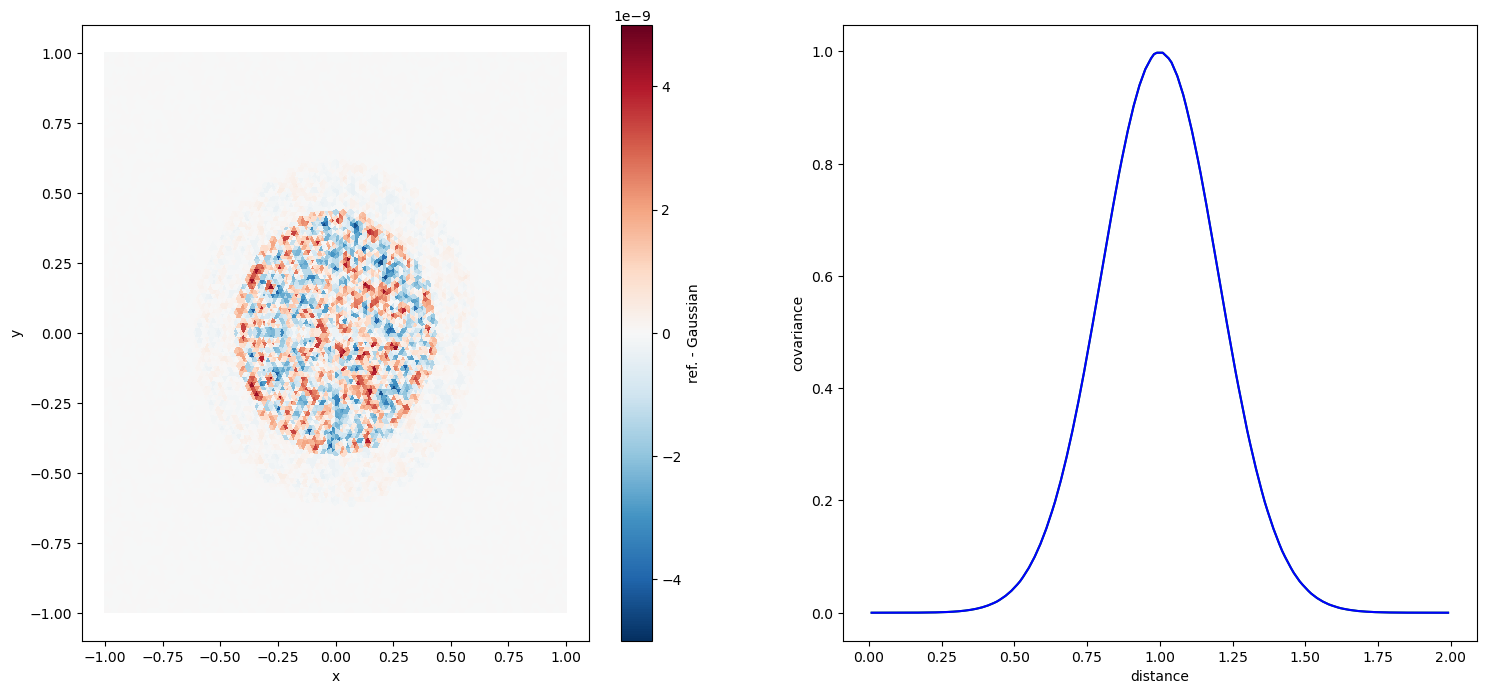

In [9]:
diff4=c3_da-res_da4
# Plot unstructured grid and cross section
fig1, (ax0, ax1) = plt.subplots(ncols=2,figsize=(18, 8))
diff4.ugrid.plot(ax=ax0,cbar_kwargs={'label': "ref. - Gaussian"})


ax1.plot(line[axis_name].values,c3_line,'green') 
ax1.plot(line[axis_name].values,res_line4,color="blue") 
plt.xlabel("distance")
plt.ylabel("covariance")
plt.show()

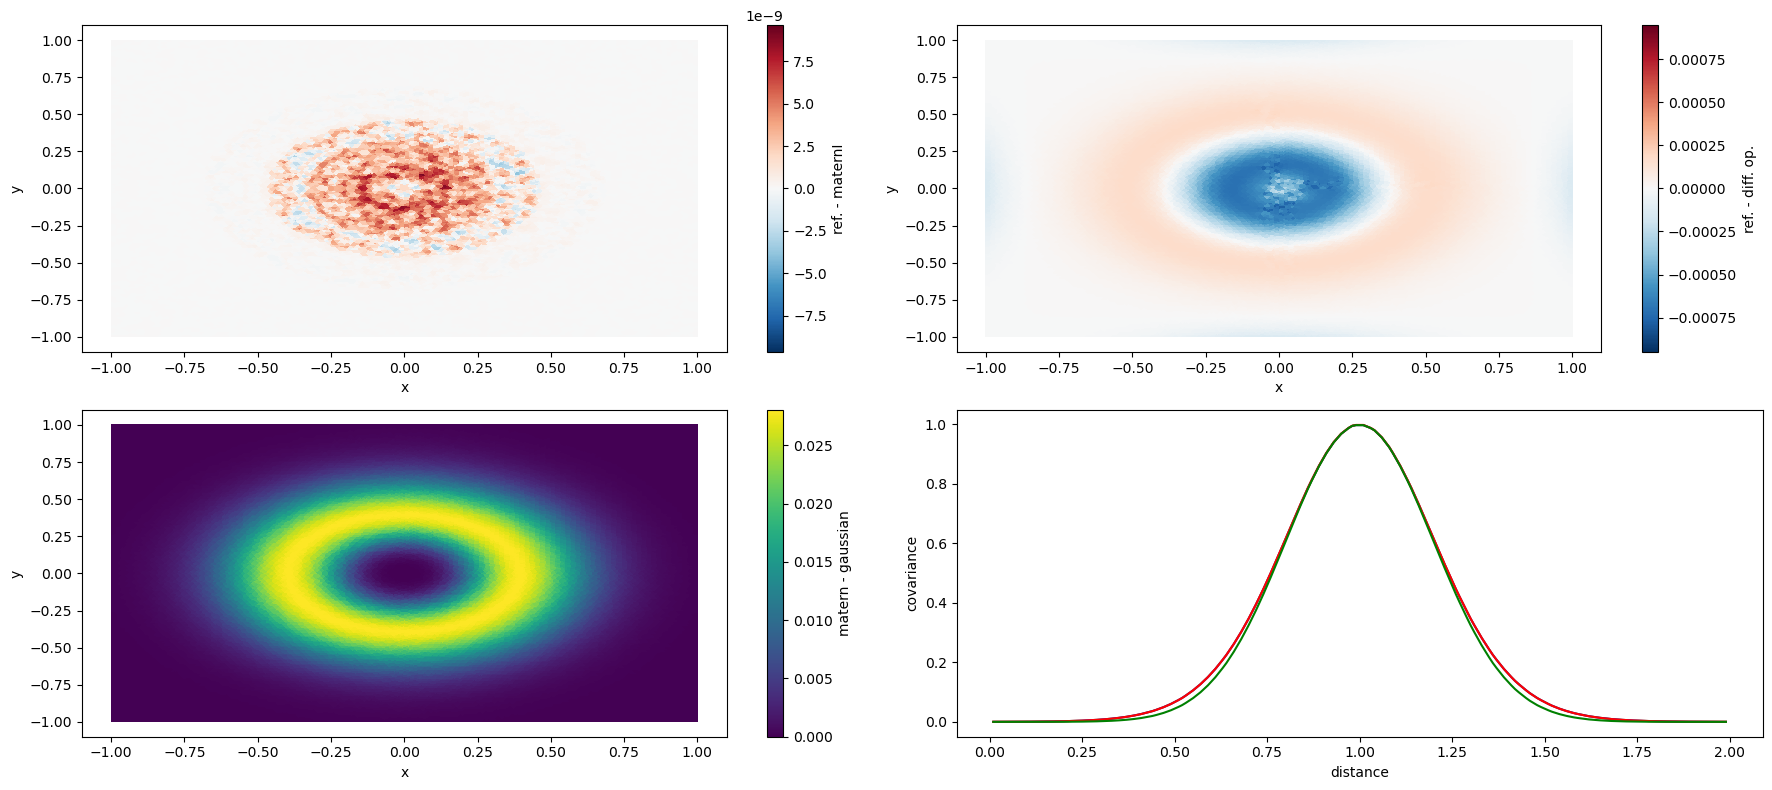

In [10]:
diff5=c4_da-res_da5
diff6=c4_da-res_da6
diff0=c4_da-c3_da

# Plot unstructured grid and cross section
fig1, ((ax0, ax1),(ax2,ax3)) = plt.subplots(ncols=2,nrows=2,figsize=(18, 8))
diff5.ugrid.plot(ax=ax0,cbar_kwargs={'label': "ref. - maternI"})
diff6.ugrid.plot(ax=ax1,cbar_kwargs={'label': "ref. - diff. op."})
diff0.ugrid.plot(ax=ax2,cbar_kwargs={'label': "matern - gaussian"})


ax3.plot(line[axis_name].values,c4_line,'yellow') 
ax3.plot(line[axis_name].values,res_line5,color="blue") 
ax3.plot(line[axis_name].values,res_line6,color="red")
ax3.plot(line[axis_name].values,c3_line,'green') 
plt.xlabel("distance")
plt.ylabel("covariance")

plt.tight_layout()

#